* optimization
 - scipy.optimize
 - [pyDE](https://github.com/hpparvi/PyDE)
 - [optuna](https://github.com/optuna/optuna)

In [13]:
import matplotlib.pyplot as pl
import pandas as pd
import matplotlib as mpl
mpl.style.use("fivethirtyeight")

## scipy.optimize

In [8]:
import numpy as np

def true_model(params, t=None):
    '''Return x(t) given params'''
    A, omega = params
    x = A * np.sin(omega*t) #+ B * np.cos(omega*t)
    return x

def chi_squared(params, data=None, model=None, t=None, sigma=None):
    '''Return the chi squared for a model'''
    residual = data - model(params, t=t)
    return np.mean(residual**2 / sigma**2)

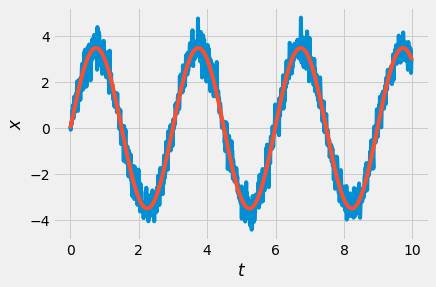

In [7]:
A, omega = 3.5, 2.1
sigma = 0.42
t = np.arange(0, 10, 0.01)

x_noise_free = true_model([A, omega], t=t)
x_data = x_noise_free + np.random.normal(scale=sigma, size=len(t))

pl.plot(t, x_data); 
pl.plot(t, x_noise_free, '-'); 
pl.xlabel('$t$'); 
pl.ylabel('$x$');

In [9]:
guess = np.array([1.7, 1.67])

chi_squared(guess, data=x_data, model=true_model, t=t, sigma=sigma)

51.199888138138185

In [14]:
from scipy.optimize import minimize

result = minimize(chi_squared, 
                  guess, 
                  args=(x_data, true_model, t, sigma),
                  method='BFGS'
                 )
result.success, result.x

(True, array([3.48758741, 2.09998434]))

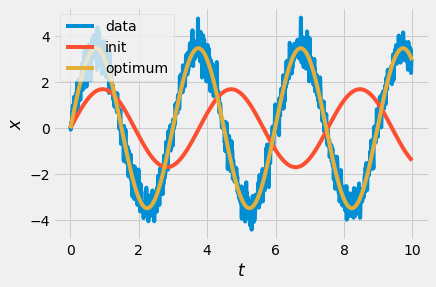

In [16]:
x_init = true_model(guess, t=t)
x_fit = true_model(result.x, t=t)

pl.plot(t, x_data, label='data'); 
pl.plot(t, x_init, label='init'); 
pl.plot(t, x_fit, label='optimum'); 
pl.xlabel('$t$'); 
pl.ylabel('$x$');
pl.legend()

## Gradient-based: Newton-CGS & jax

In [8]:
import jax
jax.__version__

'0.1.64'

In [ ]:
import matplotlib.pyplot as pl
import pandas as pd
import matplotlib as mpl
mpl.style.use("fivethirtyeight")

In [30]:
A, omega = 3.5, 2.1
sigma = 0.42
t = np.arange(0, 10, 0.01)

x_noise_free = true_model([A, omega], t=t)
x_data = x_noise_free + np.random.normal(scale=sigma, size=len(t))

In [36]:
from jax import grad, vmap, value_and_grad, jit

def true_model(params, t=None):
    '''Return x(t) given params'''
    A, omega = params
    x = A * jnp.sin(omega*t) #+ B * np.cos(omega*t)
    return x

def diff_eq_residuals(t, model_params=None, model=None):
    '''
    The residuals of the differential equation.
    These *should* be a vector of zeros
    
    xddot + omega^2 x = 0
    '''
    # x(t)
    x_of_t = lambda t_values: model(model_params, t_values)
    x = x_of_t(t)

    # First derivative
    x_dot_func = grad(x_of_t)
    x_dot = vmap(x_dot_func)(t)

    # Second derivative
    x_ddot_func = grad(x_dot_func)
    x_ddot = vmap(x_ddot_func)(t)
    
    omega = model_params[1]
    return x_ddot + omega**2 * x

In [41]:
residuals = diff_eq_residuals(t, [A, omega], true_model)
jnp.allclose(residuals, 0, rtol=1e-5)

DeviceArray(False, dtype=bool)

In [14]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [42]:
from scipy.optimize import minimize

guess = np.array([1.7, 1.67]) #true=3.5, 2.1
result = minimize(value_and_grad(chi_squared), 
                  guess, 
                  args=(x_data, true_model, t, sigma), 
                  jac=True, 
                  method='Newton-CG'
                 )
result

     fun: DeviceArray(4.922849, dtype=float32)
     jac: DeviceArray([-6.7223325, -0.4093635], dtype=float32)
 message: 'Optimization terminated successfully.'
    nfev: 16
    nhev: 0
     nit: 9
    njev: 50
  status: 0
 success: True
       x: DeviceArray([2.3536024, 2.1007528], dtype=float32)

https://github.com/gully/TgiF/blob/master/notebooks/05_Can_Jax_satisfy_differential_equations.ipynb

In [18]:
def chi_squared(params, data=None, model=None, t=None, sigma=None):
    '''Return the chi squared for a model'''
    residual = data - model(params, t=t)
    return jnp.mean(residual**2 / sigma**2)

def phenomenological_model(params, t=None):
    '''Return x(t) given params'''
    return jnp.polyval(params, t)

def least_squares_fit(t, x, order=10, sigma=0.42):
    '''return the least squares fit to the data'''
    A = jnp.vander(t, order)
    ATA = jnp.dot(A.T, A / sigma**2)
    sigma_w = jnp.linalg.inv(ATA)
    mean_w = jnp.linalg.solve(ATA, jnp.dot(A.T, x/sigma**2))
    return mean_w

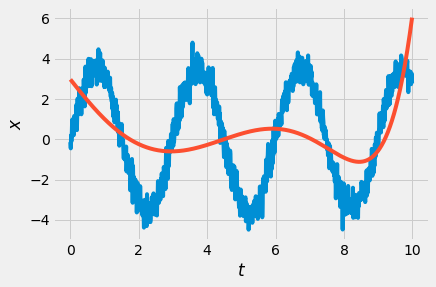

In [28]:
coeffs = least_squares_fit(t, x_data, order=10)

pl.plot(t, x_data); pl.xlabel('$t$'); pl.ylabel('$x$');
pl.plot(t, phenomenological_model(coeffs, t=t));

## optuna
Code based on the [tutorial](https://github.com/optuna/optuna/blob/master/examples/quadratic_simple.py)

In [ ]:
import optuna
optuna.__version__

def objective(trial):
    x = trial.suggest_uniform("x", -100, 100)
    y = trial.suggest_categorical("y", [-1, 0, 1])
    return x ** 2 + y

# Let us minimize the objective function above.
print("Running 10 trials...")
study = optuna.create_study()
study.optimize(objective, n_trials=10)
print("Best value: {} (params: {})\n".format(study.best_value, study.best_params))

# We can continue the optimization as follows.
print("Running 20 additional trials...")
study.optimize(objective, n_trials=20)
print("Best value: {} (params: {})\n".format(study.best_value, study.best_params))

# We can specify the timeout instead of a number of trials.
# print("Running additional trials in 2 seconds...")
# study.optimize(objective, timeout=2.0)
# print("Best value: {} (params: {})\n".format(study.best_value, study.best_params))